In [97]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio
import utils.plotFunctions as pf
import utils.helperFunctions as hf
import os,sys
from PIL import Image,ImageOps

imageSize = (64,64)
dictSize = 64
sampleSize = 100

# Sparse Coding hyperparameters
numTrials = 400  # Number of weight update steps
numInputs =  64 # pixels
numOutputs = 64  # number of neurons (dictionary size)
lambdav = 0.5 # activation threshold
batchSize = 64  # Number of samples to use in a single weight update
eta = 0.1 # Learning rate

# Inference hyperparameters
tau = 100 # LCA update time constant
numInferenceSteps = 4 # Number of iterations to run LCA

# Plot display parameters
displayInterval = 400 # How often to update display plots during learning
displayStatsInterval = 10  # How often to update the stats plots
#


Final sparsity:  0.724853515625 0.266845703125
Avg error:  0.097518444627273 0.26878329140481316


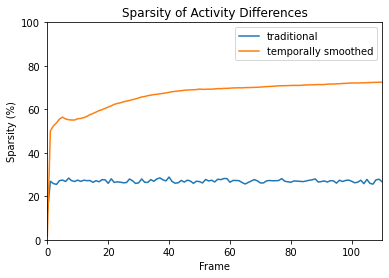

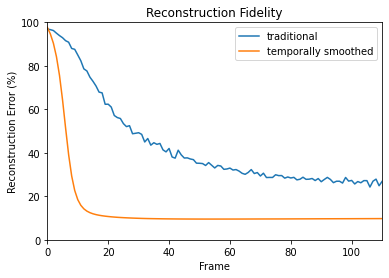

In [98]:
# GREYSCALE
def patches2FullImage(patches,i_size,p_size):
    grey = []
    row = []
    reshaped = []
    for patch_id in range(len(patches[0])): # for each patch
        patch = patches[:,patch_id]
        layer = np.reshape(patch,p_size)
        reshaped.append(layer)
    reconstruction = []
    for i in range(int(i_size[0]/p_size[0])):
        row = []
        for j in range(int(i_size[1]/p_size[1])):
            row.append(reshaped[i*8+j])

        reconstruction.append(np.hstack(tuple(row)))

    reconstruction = np.vstack(tuple(reconstruction))
    return reconstruction.flatten()

# GREYSCALE
def fullImage2Patches(image,i_size,p_size):
    # Make batch of random image
    patches = np.zeros((numInputs, batchSize))  # getting sequential 8x8 RGB patches (192 pixels each)
    square = np.reshape(image,i_size)
    for i in range(int(i_size[0]/p_size[0])):
        for j in range(int(i_size[1]/p_size[1])):
            patch = square[8*i:8+8*i,8*j:8+8*j].flatten()
            patches[:,i*8+j] = patch
    return patches


def threshold(u, lambdav):
    """
    Compute the activity of the neurons using the membrane potentials (u) using soft thresholding:

    a = T(u) = u - threshold, u > threshold
               u + threshold, u < -threshold
               0, otherwise
    """
    a = np.abs(u) - lambdav
    a[np.where(a<0)] = 0
    a = np.sign(u) * a
    return a


def inference(dataBatch, phi, tau, lambdav, numInferenceSteps, u_prev,trial,image_num,mean=0,std=1,):
    """
    Compute

    Parameters
    ----------
    dataBatch : Batch of data samples, shape=(numInputs, batchSize)
    phi : Dictionary, shape=(numInputs, numOutputs)
    tau : Time Constant of LCA update, scalar float
    lambdav : Both the sparsity tradeoff term and the LCA Threshold value
    numInferenceSteps: Number of inference steps to take

    Returns
    -------
    a : Activity, i.e. thresholded potentials, shape=(numOutputs, batchSize)
    """
    b = phi.T @ dataBatch # Driving input (64 x 64)
    gramian = phi.T @ phi - np.identity(int(phi.shape[1])) # Explaining away matrix (64 x 64)
    u = u_prev
    # Initialize membrane potentials to 0
    for step in range(numInferenceSteps):
        a = threshold(u, lambdav) # Activity vector contains thresholded membrane potentials
        du = b - u - gramian @ a # LCA dynamics define membrane update (equation (5))
        u += (1.0 / tau) * du # Update membrane potentials using time constant

    return u, threshold(u, lambdav)


def weightUpdate(phi, dataBatch, activity, learningRate):
    dataBatchReconstruction = phi @ activity # Reconstruct input using the neuron activity (stimulus approximation)
    reconstructionError =  dataBatch - dataBatchReconstruction # Error between the input and reconstruction
    dPhi = reconstructionError @ activity.T  # Weight update rule (dE/dPhi)
    phi = phi + learningRate * dPhi # Scale weight update by learning rate
    return (phi, reconstructionError)

images = hf.get_frames('moshe_walk',(64,64))

def trainModel(dataset,temp_smooth):
    # # Plotting
    MSE = []
    sparsityPercentage = []
    # Initialize Phi weight matrix with random values
    np.random.seed(0)
    phi = hf.l2Norm(np.random.randn(numInputs, numOutputs))

    # prevFig = pf.plotDataTiled(phi, "Dictionary at image 0", None)
    learningRate = eta / batchSize
    # Do sparse coding with LCA

    u_prev = np.random.uniform(-1,1,(64,64))
    activity_prev = threshold(lambdav,u_prev)
    sparsity_measures = []
    recon_accs = []
    for image_num in range(len(dataset)):
        image = 1/(1+np.exp(-np.array(dataset[image_num])))

        # Make batch of random image
        dataBatch = fullImage2Patches(image,(64,64),(8,8))
        u_rand = np.random.uniform(-1,1,(64,64))
        if temp_smooth == True:
            u_prev, activity = inference(dataBatch, phi, tau, lambdav, numInferenceSteps,u_prev,0,image_num,0,0)
        else:
            u_prev, activity = inference(dataBatch, phi, tau, lambdav, numInferenceSteps,u_rand,0,image_num,0,0)

        # HISTOGRAM OF ACTIVITY

        y_hist = 150*abs(activity_prev-activity).flatten()
        y_hist = -np.sort(-y_hist)
        sparsity = 1-(np.count_nonzero(y_hist)/len(y_hist))
        sparsity_measures.append(sparsity)
        # if image_num==80:
        #     x_hist = np.arange(1,len(y_hist)+1)
        #     plt.bar(x_hist,y_hist)
        #     plt.ylim((0,1))
        #     plt.xlabel('Feature')
        #     plt.ylabel('150x Absolute Difference\n in Activity')
        #     plt.title('Temporally Smoothed LCA:\n Histogram of Differences')
        #     # plt.savefig('reg_hist80.png',dpi=300)
        #     plt.show()

        # Renormalize phi matrix
        phi = hf.l2Norm(phi)
        (phi, reconstructionError) = weightUpdate(phi, dataBatch, activity, learningRate)
        recon_accs.append(np.sum(abs(reconstructionError))/64**2)
        activity_prev = activity

    return np.array(sparsity_measures),np.array(recon_accs)
# trainModel(images,True) # moshe_walk

def plots():
    # sparsity of activity differences
    smooth_sparsity,smooth_fidelity = trainModel(images,True)
    trad_sparsity,trad_fidelity = trainModel(images,False)
    print("Final sparsity: ", smooth_sparsity[-1],trad_sparsity[-1])
    print("Avg error: ", smooth_fidelity[-1],trad_fidelity[-1])

    plt.plot(np.arange(0,len(trad_sparsity),1),100*trad_sparsity,label="traditional")
    plt.plot(np.arange(0,len(smooth_sparsity),1),100*smooth_sparsity,label="temporally smoothed")
    plt.ylabel("Sparsity (%)")
    plt.xlabel("Frame")
    plt.title("Sparsity of Activity Differences")
    plt.legend()
    plt.ylim((0,100))
    plt.xlim((0,110))
    # plt.savefig('actDiffSparsity.png',dpi=300)
    plt.show()

    plt.plot(np.arange(0,len(trad_fidelity),1),100*trad_fidelity,label="traditional")
    plt.plot(np.arange(0,len(smooth_fidelity),1),100*smooth_fidelity,label="temporally smoothed")
    plt.ylabel("Reconstruction Error (%)")
    plt.xlabel("Frame")
    plt.title("Reconstruction Fidelity")
    plt.legend()
    plt.ylim((0,100))
    plt.xlim((0,110))
    # plt.savefig("recFidelity.png",dpi=300)
    plt.show()
plots()